# Interpret your PyTorch model with Captum

This notebook demonstrates how to use the methods available in Captum. It isn't focused on gaining information from the results. Rather it aims to give you information about how to implement Captum in your own project.

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Interpreting-PyTorch-models-with-Captum/blob/master/Interpret_your_PyTorch_model_with_Captum.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Interpreting-PyTorch-models-with-Captum/blob/master/Interpret_your_PyTorch_model_with_Captum.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

In [0]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


 ship horse plane   car


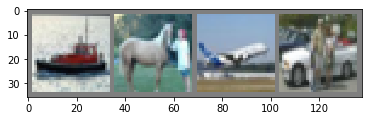

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
for epoch in range(8):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.253
[1,  4000] loss: 1.939
[1,  6000] loss: 1.694
[1,  8000] loss: 1.601
[1, 10000] loss: 1.521
[1, 12000] loss: 1.503
[2,  2000] loss: 1.417
[2,  4000] loss: 1.400
[2,  6000] loss: 1.350
[2,  8000] loss: 1.350
[2, 10000] loss: 1.328
[2, 12000] loss: 1.328
[3,  2000] loss: 1.256
[3,  4000] loss: 1.216
[3,  6000] loss: 1.247
[3,  8000] loss: 1.220
[3, 10000] loss: 1.202
[3, 12000] loss: 1.207
[4,  2000] loss: 1.117
[4,  4000] loss: 1.134
[4,  6000] loss: 1.138
[4,  8000] loss: 1.135
[4, 10000] loss: 1.138
[4, 12000] loss: 1.108
[5,  2000] loss: 1.059
[5,  4000] loss: 1.064
[5,  6000] loss: 1.044
[5,  8000] loss: 1.052
[5, 10000] loss: 1.064
[5, 12000] loss: 1.060
[6,  2000] loss: 0.968
[6,  4000] loss: 0.987
[6,  6000] loss: 1.000
[6,  8000] loss: 0.998
[6, 10000] loss: 1.003
[6, 12000] loss: 1.027
[7,  2000] loss: 0.925
[7,  4000] loss: 0.944
[7,  6000] loss: 0.946
[7,  8000] loss: 0.960
[7, 10000] loss: 0.978
[7, 12000] loss: 0.981
[8,  2000] loss: 0.865
[8,  4000] 

GroundTruth:    cat  ship  ship plane


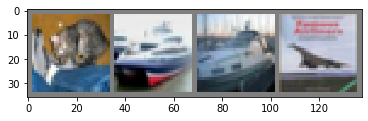

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
outputs = net(images)

In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


# Install Captum

Installing Captum is super simple. All you need is a simple pip install.

In [0]:
!pip install captum

# General Attribution Techniques

First we can take a look at what features are actually important to the model when making predictions. Captum has multiple methods for this. For more information about the theory behind these methods take a look at the [official documentation](https://captum.ai/docs/algorithms#general-attribution).

In [0]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

Pick a test image to analyse.

In [0]:
ind = 3

input = images[ind].unsqueeze(0)
input.requires_grad = True

In [0]:
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
)

In [0]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions

In [0]:
saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))
print(grads.shape)

(32, 32, 3)


In [0]:
ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.0240])


In [0]:
ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      n_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

In [0]:
dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

/usr/local/lib/python3.6/dist-packages/captum/attr/_core/deep_lift.py:327: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


Predicted: horse  Probability: 0.981583297252655


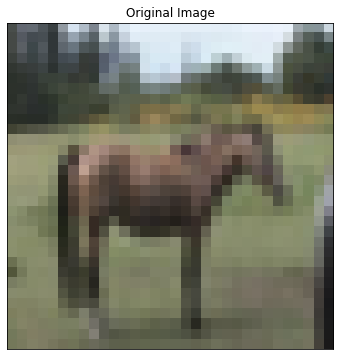

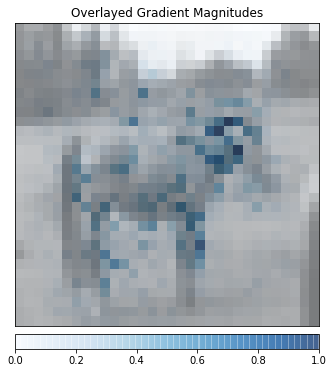

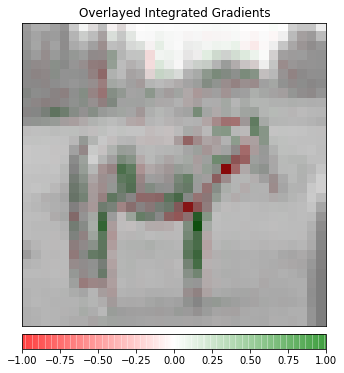

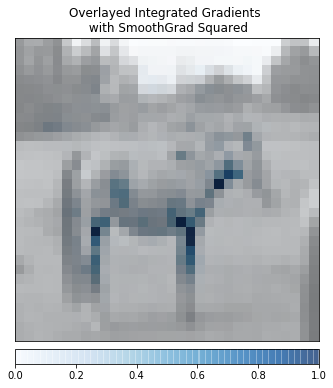

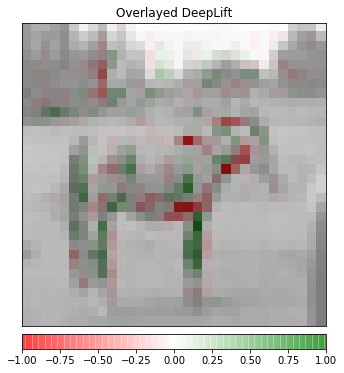

In [0]:
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")

# Layer Attribution Techniques

In [0]:
from captum.attr._core.layer_conductance import LayerConductance
from captum.attr._core.layer_activation import LayerActivation
from captum.attr._core.internal_influence import InternalInfluence
from captum.attr._core.layer_gradient_x_activation import LayerGradientXActivation

In [0]:
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, text=True, axis_title="Features"):
    if text:
        print(title)
        for i in range(len(feature_names)):
            print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)

In [0]:
layer_cond = LayerConductance(net, net.fc3)
attr_lc = layer_cond.attribute(input, target=labels[ind].item()).detach().numpy()

Average Neuron Importances
0 :  0.000
1 :  0.000
2 :  0.000
3 :  0.000
4 :  0.000
5 :  0.000
6 :  0.000
7 :  9.560
8 :  0.000
9 :  0.000


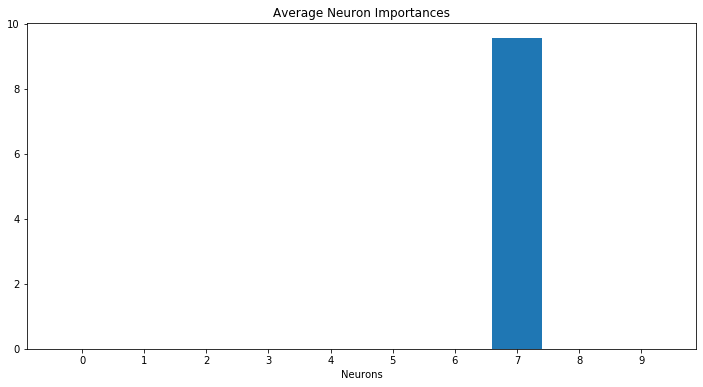

In [0]:
visualize_importances(range(10),np.mean(attr_lc, axis=0),title="Average Neuron Importances", axis_title="Neurons")

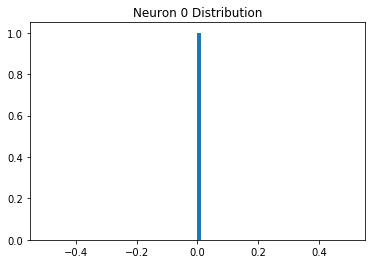

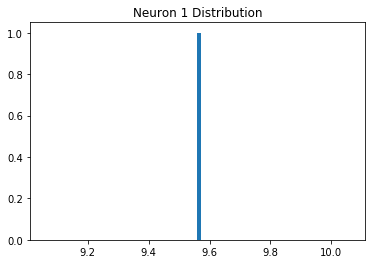

In [0]:
plt.hist(attr_lc[:,0], 100);
plt.title("Neuron 0 Distribution")
plt.figure()
plt.hist(attr_lc[:,7], 100);
plt.title("Neuron 1 Distribution");

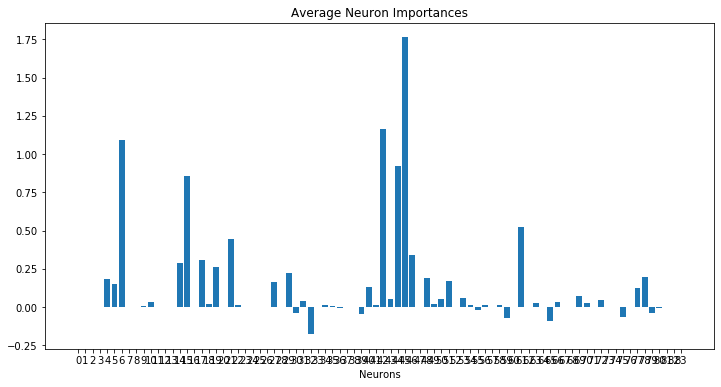

In [0]:
layer_cond = LayerConductance(net, net.fc2)
attr_lc = layer_cond.attribute(input, target=labels[ind].item()).detach().numpy()
visualize_importances(range(84),np.mean(attr_lc, axis=0),title="Average Neuron Importances", axis_title="Neurons", text=False)

In [0]:
layer_act = LayerActivation(net, net.fc3)
attr_la = layer_cond.attribute(input, target=labels[ind].item()).detach().numpy()

In [0]:
layer_int_inf = InternalInfluence(net, net.fc3)
attr_lii = layer_int_inf.attribute(input, target=labels[ind].item())

In [0]:
layer_ga = LayerGradientXActivation(net, net.fc3)
attr_lg = layer_ga.attribute(input, target=labels[ind].item())

# Neuron Attribution Techniques

In [0]:
from captum.attr._core.neuron_gradient import NeuronGradient
from captum.attr._core.neuron_integrated_gradients import NeuronIntegratedGradients
from captum.attr._core.neuron_conductance import NeuronConductance

In [0]:
neuron_g = NeuronGradient(net, net.conv1)
attr_ng = neuron_g.attribute(input, neuron_index=(4, 1, 2))
attr_ng = np.transpose(attr_ng.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [0]:
neuron_ig = NeuronIntegratedGradients(net, net.conv1)
attr_nig = neuron_ig.attribute(input, neuron_index=(4, 1, 2))
attr_nig = np.transpose(attr_nig.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [0]:
neuron_cond = NeuronConductance(net, net.conv1)
attr_cond = neuron_cond.attribute(input, neuron_index=(4, 1, 2), target=labels[ind].item())
attr_cond = np.transpose(attr_cond.squeeze().cpu().detach().numpy(), (1, 2, 0))

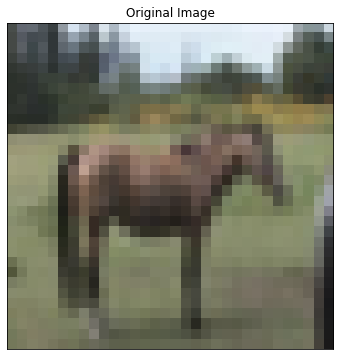

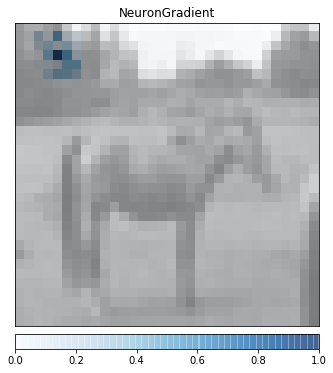

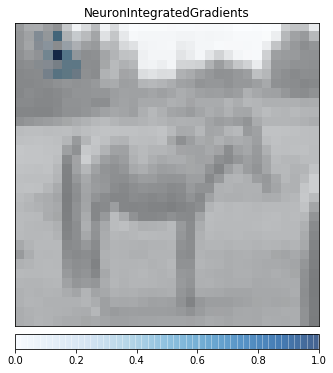

/usr/local/lib/python3.6/dist-packages/captum/attr/_utils/visualization.py:42: UserWarning: Attempting to normalize by value approximately 0, skipping normalization.This likely means that attribution values are all close to 0.
  "Attempting to normalize by value approximately 0, skipping normalization."


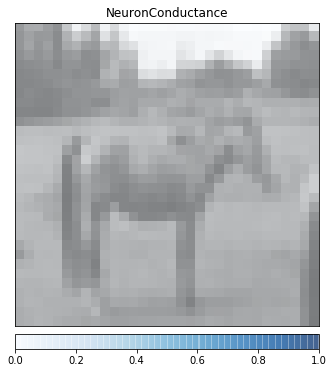

In [0]:
original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(attr_ng, original_image, method="blended_heat_map",
                          show_colorbar=True, title="NeuronGradient")

_ = viz.visualize_image_attr(attr_nig, original_image, method="blended_heat_map",
                          show_colorbar=True, title="NeuronIntegratedGradients")

_ = viz.visualize_image_attr(attr_cond, original_image, method="blended_heat_map",
                          show_colorbar=True, title="NeuronConductance")

# Captum Insights

In [0]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.features import ImageFeature

In [0]:
def baseline_func(input):
    return input * 0

visualizer = AttributionVisualizer(
    models=[net],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=classes,
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=testloader,
)

In [0]:
visualizer.render(debug=False)


Fetch data and view Captum Insights at http://localhost:33459/

